Data

In [ ]:
import os
import pandas as pd

# Crear carpeta si no existe
os.makedirs("emoevent_data/es", exist_ok=True)

# URLs directas
base_url = "https://raw.githubusercontent.com/fmplaza/EmoEvent/master/splits/es"
files = ["train.tsv", "dev.tsv", "test.tsv"]

# Descargar archivo
for file in files:
    url = f"{base_url}/{file}"
    output_path = f"emoevent_data/es/{file}"
    if not os.path.exists(output_path):
        print(f"Descargando {file}...")
        pd.read_csv(url, sep="\t").to_csv(output_path, sep="\t", index=False)
    else:
        print(f"{file} ya existe.")

print("✅ Descarga completa.")


Descargando train.tsv...
Descargando dev.tsv...
Descargando test.tsv...
✅ Descarga completa.


Celda: Cargar y explorar el dataset EmoEvent (versión en español)

In [2]:

# Ruta
path = "emoevent_data/es"

# Cargar ignorando la primera fila manualmente
train = pd.read_csv(f"{path}/train.tsv", sep="\t", skiprows=1, names=["id", "event", "text", "offensive", "emotion"])
dev   = pd.read_csv(f"{path}/dev.tsv",   sep="\t", skiprows=1, names=["id", "event", "text", "offensive", "emotion"])
test  = pd.read_csv(f"{path}/test.tsv",  sep="\t", skiprows=1, names=["id", "event", "text", "offensive", "emotion"])

# Mostrar resumen
print("📊 Tamaño de los conjuntos:")
print(f"Train: {len(train)}  | Dev: {len(dev)}  | Test: {len(test)}\n")

# Ver ejemplo
print("🔍 Ejemplo de datos limpios:")
display(train.head())

# Emociones únicas y su distribución
print("📌 Emociones disponibles:")
print(train['emotion'].value_counts())

# Eventos únicos y su cantidad
print("\n📌 Eventos únicos:")
print(train['event'].value_counts().head(10))


📊 Tamaño de los conjuntos:
Train: 5723  | Dev: 844  | Test: 1656

🔍 Ejemplo de datos limpios:


,id,event,text,offensive,emotion
0,a0c1a858-a9b8-4cb1-8a81-1602736ff5b8,GameOfThrones,La Gran Guerra de #JuegoDeTronos nos ha dejado...,NO,others
1,9b272817-a231-4f68-bdf4-3350d4919330,Venezuela,El golpe de Estado en #Venezuela está más lejo...,NO,others
2,4bd5b1e5-4b74-440a-82f4-c2567a241011,NotreDame,No tengo una foto en la catedral de #NotreDame...,NO,sadness
3,0bb9d7c9-d781-4684-890e-a94bfb50acc0,NotreDame,#NotreDame nunca llegue a visitar tan grandios...,NO,sadness
4,88749098-d539-4500-9209-0bbfae2b109c,GameOfThrones,A tomar por culo mi crush 😭😭😭😭😭#JuegoDeTronos,OFF,sadness


📌 Emociones disponibles:
emotion
others      2800
joy         1227
sadness      693
anger        589
surprise     238
disgust      111
fear          65
Name: count, dtype: int64

📌 Eventos únicos:
event
GameOfThrones      837
NotreDame          834
SpainElection      831
Venezuela          824
ChampionsLeague    813
WorldBookDay       775
GretaThunberg      416
LaLiga             393
Name: count, dtype: int64


In [ ]:
# 🔐 Celda para ingresar tu API Key (NO subir a GitHub)
import os

# Puedes correr esta celda y pegar tu API cuando te lo pida
OPENAI_API_KEY = input(" Ingresa tu API Key de OpenAI: ")

# Guardarla temporalmente como variable de entorno (opcional)
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

print("✅ API Key cargada correctamente.")


In [72]:
# 📦 Instalar si estás en Colab o local (si no lo tienes)
!pip install openai --upgrade

In [ ]:
from openai import OpenAI
import os


client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

# Emociones válidas
valid_labels = ['anger', 'sadness', 'joy', 'disgust', 'fear', 'surprise', 'offensive', 'other']

def clasificar_emocion_gpt(tweet_text):
    prompt = (
        "Clasifica el siguiente tweet en una sola palabra que indique la emoción principal. "
        "Responde solo con una de las siguientes opciones exactas (en minúsculas): "
        "anger, sadness, joy, disgust, fear, surprise, offensive, other.\n\n"
        f"Tweet: \"{tweet_text}\"\n\n"
        "Respuesta:"
    )

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[{"role": "user", "content": prompt}],
            temperature=0,
            max_tokens=10,
        )
        raw_response = response.choices[0].message.content.strip().lower()

        # Filtrar y devolver solo etiquetas válidas
        for label in valid_labels:
            if label == raw_response:
                return label
        return "invalid"
    except Exception as e:
        print("❌ Error en GPT:", e)
        return "error"


In [60]:
tweet_ejemplo = "Estoy muy feliz con los resultados del partido."
print("Predicción GPT-4o:", clasificar_emocion_gpt(tweet_ejemplo))


Predicción GPT-4o: joy


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

# Definir emociones válidas
valid_labels = ['anger', 'sadness', 'joy', 'disgust', 'fear', 'surprise', 'offensive', 'other']

#  Limpiar test y tomar muestra
test_clean = test.dropna(subset=["text", "emotion"])
test_clean = test_clean[test_clean['emotion'].isin(valid_labels)].reset_index(drop=True)

# Tomamos muestra aleatoria de 50 ejemplos
test_sample = test_clean.sample(n=50).reset_index(drop=True)

# Inicializar listas de predicción y reales
y_true = []
y_pred = []

print("🧠 Clasificando 50 tweets con GPT-4o...\n")
for _, row in tqdm(test_sample.iterrows(), total=len(test_sample)):
    tweet = str(row['text']).strip()
    true_emotion = row['emotion'].lower()

    pred_emotion = clasificar_emocion_gpt(tweet)

    y_true.append(true_emotion)
    y_pred.append(pred_emotion)


🧠 Clasificando 50 tweets con GPT-4o...



100%|██████████| 50/50 [00:33<00:00,  1.48it/s]


In [68]:
# Reporte de métricas por emoción
print("📊 Reporte de métricas por emoción (GPT-4o)")
print(classification_report(y_true, y_pred, labels=valid_labels, digits=3))



📊 Reporte de métricas por emoción (GPT-4o)
              precision    recall  f1-score   support

       anger      0.455     0.333     0.385        15
     sadness      0.200     0.167     0.182         6
         joy      0.400     0.273     0.324        22
     disgust      0.000     0.000     0.000         1
        fear      0.400     0.667     0.500         3
    surprise      0.000     0.000     0.000         3
   offensive      0.000     0.000     0.000         0
       other      0.000     0.000     0.000         0

    accuracy                          0.280        50
   macro avg      0.182     0.180     0.174        50
weighted avg      0.360     0.280     0.310        50



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


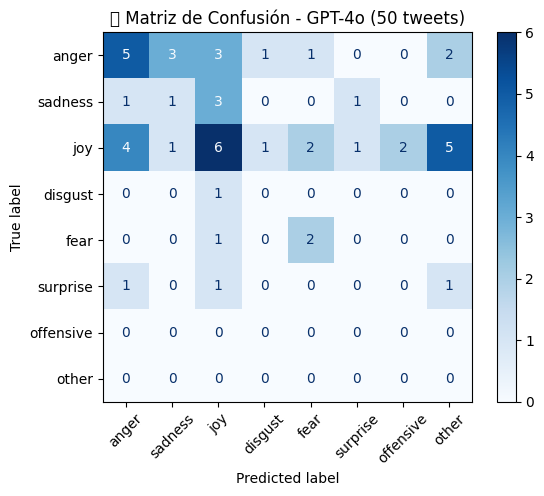

In [69]:
# Matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=valid_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=valid_labels)
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("🧠 Matriz de Confusión - GPT-4o (50 tweets)")
plt.grid(False)
plt.show()


In [71]:

# Guardamos el texto original, la etiqueta real y la predicción GPT
df_resultados = pd.DataFrame({
    "text": test_sample['text'],
    "true_emotion": y_true,
    "predicted_emotion": y_pred
})

# Guardar como CSV
df_resultados.to_csv("resultados_gpt4o_50tweets.csv", index=False, encoding="utf-8")
print("✅ Resultados guardados en 'resultados_gpt4o_50tweets.csv'")


✅ Resultados guardados en 'resultados_gpt4o_50tweets.csv'


##Plan para el Modelo 2: BERT

In [73]:
!pip install torch transformers datasets


In [8]:
# ==== BERT manual: setup + train + eval (consolidado) ====
import os, math, random, numpy as np, torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

Reproducibilidad y dispositivo

In [9]:
# ---------- 0) Reproducibilidad y dispositivo ----------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando:", device)

Usando: cuda


Normaliza y filtra correctamente

In [17]:
# Normaliza y filtra correctamente
labels = ['anger', 'sadness', 'joy', 'disgust', 'fear', 'surprise', 'offensive', 'other']
label2id = {lab: i for i, lab in enumerate(labels)}
id2label = {i: lab for lab, i in label2id.items()}

def normalize_df(df):
    df = df.dropna(subset=['text', 'emotion']).copy()
    df['emotion'] = df['emotion'].str.lower().replace("others", "other")
    df = df[df['emotion'].isin(labels)].copy()
    return df

train = normalize_df(train)
dev   = normalize_df(dev)
test  = normalize_df(test)


Tokenizador y Dataset

In [18]:
# ---------- 2) Tokenizador y Dataset ----------
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

class EmoDataset(Dataset):
    def __init__(self, df, max_length=64):
        self.texts = df['text'].tolist()
        self.y = [label2id[e] for e in df['emotion']]
        self.max_length = max_length

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        enc = tokenizer(
            str(self.texts[idx]),
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.y[idx], dtype=torch.long)
        return item

train_ds = EmoDataset(train, max_length=64)
dev_ds   = EmoDataset(dev,   max_length=64)
test_ds  = EmoDataset(test,  max_length=64)

DataLoaders

In [19]:
# ---------- 3) DataLoaders ----------
BATCH_TRAIN = 16
BATCH_EVAL  = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_TRAIN, shuffle=True)
dev_loader   = DataLoader(dev_ds,   batch_size=BATCH_EVAL)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_EVAL)

Seleccionando modelo

In [27]:
from collections import Counter

cnt = Counter([label2id[e] for e in train['emotion']])
total = sum(cnt.values())

weights = []
for i in range(len(labels)):
    if cnt[i] > 0:
        weights.append(total / cnt[i])
    else:
        # si no hay ejemplos de esa clase en train, ponemos peso 0
        weights.append(0.0)

weights = torch.tensor(weights, dtype=torch.float32).to(device)
print("Pesos por clase:", dict(zip(labels, weights.tolist())))

# Modelo y optimizador
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=len(labels)
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)



Pesos por clase: {'anger': 9.716468811035156, 'sadness': 8.258296966552734, 'joy': 4.66422176361084, 'disgust': 51.55855941772461, 'fear': 88.04615020751953, 'surprise': 24.046218872070312, 'offensive': 0.0, 'other': 2.043928623199463}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Configuracion de Helper y balanceo

In [28]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# ---------- 5) Funciones helper ----------
def run_epoch(model, loader, optimizer=None, max_grad_norm=1.0):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()
    total_loss = 0.0
    y_true, y_pred = [], []

    pbar = tqdm(loader, desc="Train" if is_train else "Eval", leave=False)
    for batch in pbar:
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        with torch.set_grad_enabled(is_train):
            outputs = model(input_ids, attention_mask=attention_mask)
            # ⚖️ CrossEntropy con pesos balanceados
            loss = torch.nn.functional.cross_entropy(outputs.logits, labels, weight=weights)

            if is_train:
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=1)
        y_true.extend(labels.detach().cpu().numpy().tolist())
        y_pred.extend(preds.detach().cpu().numpy().tolist())

    avg_loss = total_loss / max(1, len(loader))
    return avg_loss, np.array(y_true), np.array(y_pred)


def eval_and_report(y_true, y_pred, split_name="Dev"):
    # Fuerza el orden de etiquetas 0..7 para que coincida con `labels`
    ordered_label_ids = list(range(len(labels)))
    print(f"\n📊 Reporte de métricas ({split_name} - BERT manual):")
    print(classification_report(
        y_true, y_pred,
        labels=ordered_label_ids,
        target_names=labels,
        digits=3,
        zero_division=0  # evita warnings cuando una clase no aparece
    ))
    cm = confusion_matrix(y_true, y_pred, labels=ordered_label_ids)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(xticks_rotation=45, cmap="Blues")
    plt.title(f"Matriz de Confusión - BERT manual ({split_name})")
    plt.grid(False)
    plt.show()

Entrenamiento

Época 1/5 | loss_train=1.7863 | loss_dev=1.5651

📊 Reporte de métricas (Dev - BERT manual):
              precision    recall  f1-score   support

       anger      0.254     0.600     0.357        85
     sadness      0.667     0.750     0.706       104
         joy      0.421     0.337     0.374       181
     disgust      0.000     0.000     0.000        16
        fear      0.000     0.000     0.000         9
    surprise      0.145     0.514     0.226        35
   offensive      0.000     0.000     0.000         0
       other      0.724     0.449     0.554       414

    accuracy                          0.467       844
   macro avg      0.276     0.331     0.277       844
weighted avg      0.559     0.467     0.484       844



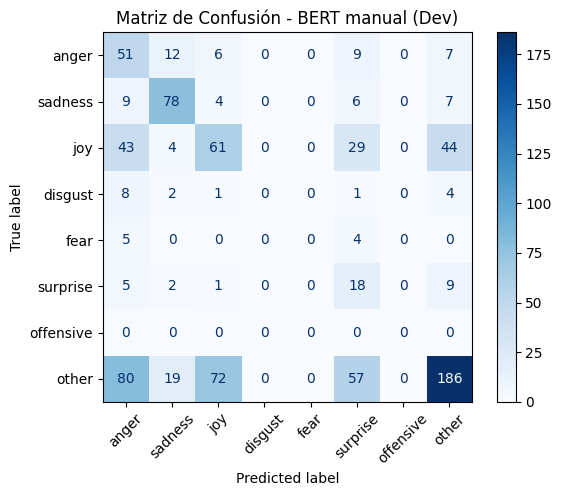

Época 2/5 | loss_train=1.4922 | loss_dev=1.4238

📊 Reporte de métricas (Dev - BERT manual):
              precision    recall  f1-score   support

       anger      0.381     0.694     0.492        85
     sadness      0.633     0.663     0.648       104
         joy      0.648     0.436     0.521       181
     disgust      0.000     0.000     0.000        16
        fear      0.000     0.000     0.000         9
    surprise      0.130     0.371     0.193        35
   offensive      0.000     0.000     0.000         0
       other      0.716     0.616     0.662       414

    accuracy                          0.563       844
   macro avg      0.313     0.348     0.314       844
weighted avg      0.612     0.563     0.574       844



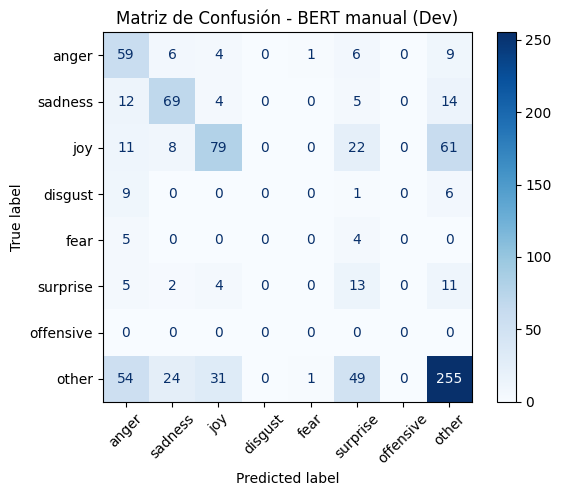

Época 3/5 | loss_train=1.2357 | loss_dev=1.3452

📊 Reporte de métricas (Dev - BERT manual):
              precision    recall  f1-score   support

       anger      0.029     0.012     0.017        85
     sadness      0.703     0.683     0.693       104
         joy      0.536     0.702     0.608       181
     disgust      0.063     0.625     0.114        16
        fear      0.211     0.444     0.286         9
    surprise      0.160     0.429     0.233        35
   offensive      0.000     0.000     0.000         0
       other      0.839     0.403     0.545       414

    accuracy                          0.468       844
   macro avg      0.317     0.412     0.312       844
weighted avg      0.626     0.468     0.499       844



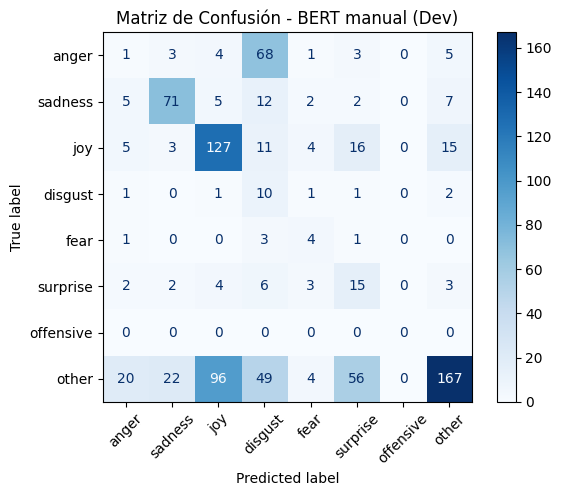

Época 4/5 | loss_train=1.0151 | loss_dev=1.3969

📊 Reporte de métricas (Dev - BERT manual):
              precision    recall  f1-score   support

       anger      0.301     0.765     0.432        85
     sadness      0.619     0.625     0.622       104
         joy      0.575     0.657     0.613       181
     disgust      0.222     0.125     0.160        16
        fear      0.571     0.444     0.500         9
    surprise      0.200     0.229     0.213        35
   offensive      0.000     0.000     0.000         0
       other      0.792     0.498     0.611       414

    accuracy                          0.556       844
   macro avg      0.410     0.418     0.394       844
weighted avg      0.637     0.556     0.569       844



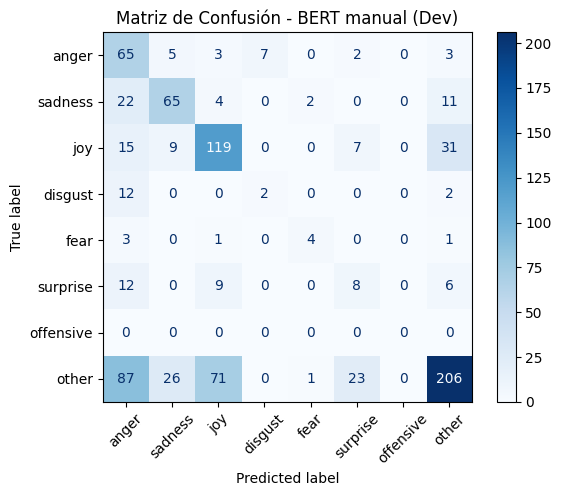

Época 5/5 | loss_train=0.7946 | loss_dev=1.7094

📊 Reporte de métricas (Dev - BERT manual):
              precision    recall  f1-score   support

       anger      0.537     0.600     0.567        85
     sadness      0.497     0.788     0.610       104
         joy      0.517     0.663     0.581       181
     disgust      0.200     0.062     0.095        16
        fear      0.214     0.333     0.261         9
    surprise      0.200     0.143     0.167        35
   offensive      0.000     0.000     0.000         0
       other      0.760     0.565     0.648       414

    accuracy                          0.588       844
   macro avg      0.366     0.394     0.366       844
weighted avg      0.613     0.588     0.586       844



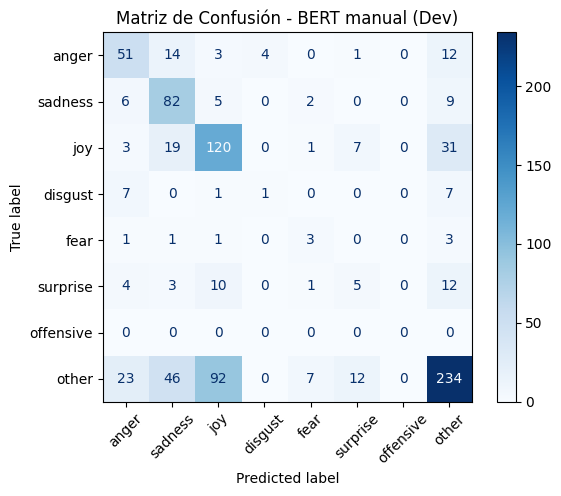

In [29]:
EPOCHS = 5
for epoch in range(EPOCHS):
    train_loss, _, _ = run_epoch(model, train_loader, optimizer=optimizer)
    dev_loss, y_dev_true, y_dev_pred = run_epoch(model, dev_loader, optimizer=None)
    print(f"Época {epoch+1}/{EPOCHS} | loss_train={train_loss:.4f} | loss_dev={dev_loss:.4f}")
    eval_and_report(y_dev_true, y_dev_pred, split_name="Dev")


Evaluación Test


✅ Evaluación Test | loss_test=3.7833

📊 Reporte de métricas (Test - BERT manual):
              precision    recall  f1-score   support

       anger      0.136     0.145     0.140       166
     sadness      0.131     0.221     0.165       195
         joy      0.247     0.293     0.268       348
     disgust      0.000     0.000     0.000        33
        fear      0.000     0.000     0.000        21
    surprise      0.060     0.045     0.051        67
   offensive      0.000     0.000     0.000         0
       other      0.529     0.407     0.460       796

    accuracy                          0.305      1626
   macro avg      0.138     0.139     0.136      1626
weighted avg      0.344     0.305     0.319      1626



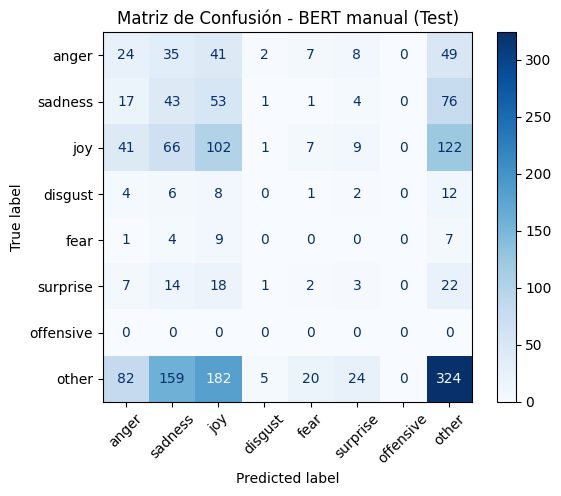

💾 Guardados: bert_manual_dev_results.csv y bert_manual_test_results.csv


In [33]:
import pandas as pd

# ---- DEV ----
dev_out = dev.reset_index(drop=True).copy()
dev_out["true"] = [id2label[i] for i in y_dev_true]
dev_out["pred"] = [id2label[i] for i in y_dev_pred]
dev_out[["text","event","true","pred"]].to_csv("bert_manual_dev_results.csv", index=False)

# ---- TEST ----
test_loss, y_test_true, y_test_pred = run_epoch(model, test_loader, optimizer=None)
print(f"\n✅ Evaluación Test | loss_test={test_loss:.4f}")
eval_and_report(y_test_true, y_test_pred, split_name="Test")

test_out = test.reset_index(drop=True).copy()
test_out["true"] = [id2label[i] for i in y_test_true]
test_out["pred"] = [id2label[i] for i in y_test_pred]
test_out[["text","event","true","pred"]].to_csv("bert_manual_test_results.csv", index=False)

print("💾 Guardados: bert_manual_dev_results.csv y bert_manual_test_results.csv")


Análisis por evento

In [35]:
def eval_por_event(df, y_pred_ids):
    tmp = df.reset_index(drop=True).copy()
    tmp["true_id"] = [label2id[e] for e in tmp["emotion"]]
    tmp["pred_id"] = y_pred_ids[:len(tmp)]
    rows = []
    for ev, g in tmp.groupby("event"):
        acc = (g["true_id"] == g["pred_id"]).mean()
        rows.append({"event": ev, "support": len(g), "accuracy": round(float(acc), 3)})
    return pd.DataFrame(rows).sort_values(["accuracy","support"], ascending=[False, False])

print("📈 DEV por evento")
display(eval_por_event(dev, y_dev_pred).head(10))

print("📉 DEV peores eventos")
display(eval_por_event(dev, y_dev_pred).tail(10))

print("🧪 TEST por evento")
display(eval_por_event(test, y_test_pred).head(10))


📈 DEV por evento


,event,support,accuracy
7,WorldBookDay,139,0.691
2,GretaThunberg,56,0.679
4,NotreDame,123,0.675
5,SpainElection,119,0.622
0,ChampionsLeague,126,0.548
3,LaLiga,44,0.523
6,Venezuela,113,0.513
1,GameOfThrones,124,0.444


📉 DEV peores eventos


,event,support,accuracy
7,WorldBookDay,139,0.691
2,GretaThunberg,56,0.679
4,NotreDame,123,0.675
5,SpainElection,119,0.622
0,ChampionsLeague,126,0.548
3,LaLiga,44,0.523
6,Venezuela,113,0.513
1,GameOfThrones,124,0.444


🧪 TEST por evento


,event,support,accuracy
2,GretaThunberg,139,0.417
7,WorldBookDay,240,0.346
3,LaLiga,119,0.345
0,ChampionsLeague,232,0.328
5,SpainElection,218,0.321
6,Venezuela,234,0.291
1,GameOfThrones,219,0.283
4,NotreDame,225,0.169


In [49]:
from transformers import BertTokenizer
import torch

bert_tok = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

def clasificar_emocion_bert(texto):
    model.eval()
    with torch.no_grad():
        tokens = bert_tok(texto, return_tensors="pt", max_length=96,
                          padding="max_length", truncation=True).to(device)
        outputs = model(**tokens)
        pred_id = torch.argmax(outputs.logits, dim=1).item()
        return id2label[pred_id]


In [54]:
tweet_ejemplo = "Estoy muy feliz con los resultados del partido."

print("Predicción BERT:", clasificar_emocion_bert(tweet_ejemplo))



Predicción BERT: joy


##BiLSTM

#importaciones

In [37]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from collections import Counter
import random, os


Preparar datos (tokenización + tensores)

In [38]:
# Asegura semillas (reproducible)
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Asegúrate de tener estas variables definidas de BERT:
# labels, label2id, id2label, train, dev, test

# Hiperparámetros
MAX_VOCAB = 30000
MAX_LEN   = 96

# Tokenizador sobre el texto de train (fit solo en train)
tok = Tokenizer(num_words=MAX_VOCAB, oov_token="<unk>")
tok.fit_on_texts(train["text"].astype(str).tolist())

def to_xy(df):
    X = tok.texts_to_sequences(df["text"].astype(str).tolist())
    X = pad_sequences(X, maxlen=MAX_LEN, padding="post", truncating="post")
    y = np.array([label2id[e] for e in df["emotion"]], dtype="int32")
    return X, y

X_train, y_train = to_xy(train)
X_dev,   y_dev   = to_xy(dev)
X_test,  y_test  = to_xy(test)

len_vocab = min(MAX_VOCAB, len(tok.word_index) + 1)
print("Vocab:", len_vocab, "| X_train:", X_train.shape, "| X_dev:", X_dev.shape, "| X_test:", X_test.shape)


Vocab: 19486 | X_train: (5723, 96) | X_dev: (844, 96) | X_test: (1626, 96)


Pesos de clase (desbalance)

In [39]:
cnt = Counter(y_train.tolist())
total = sum(cnt.values())
class_weights = {}
for i in range(len(labels)):
    class_weights[i] = (total / cnt[i]) if cnt.get(i, 0) > 0 else 0.0
print("Class weights:", class_weights)


Class weights: {0: 9.71646859083192, 1: 8.258297258297258, 2: 4.6642216788916055, 3: 51.55855855855856, 4: 88.04615384615384, 5: 24.04621848739496, 6: 0.0, 7: 2.0439285714285713}


Modelo BiLSTM

In [40]:
def build_bilstm(vocab_size, max_len, num_classes):
    inp = layers.Input(shape=(max_len,), dtype="int32")
    x = layers.Embedding(vocab_size, 128, mask_zero=True)(inp)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inp, out)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=2e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

model_lstm = build_bilstm(len_vocab, MAX_LEN, num_classes=len(labels))
model_lstm.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 96, 128)   │  2,494,208 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 96)        │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 96, 256)   │    263,168 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ bidirectional[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 8)         │      1,032 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,791,304 (10.65 MB)

 Trainable params: 2,791,304 (10.65 MB)

 Non-trainable params: 0 (0.00 B)

Entrenamiento (con EarlyStopping)

In [41]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
]

history = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_dev, y_dev),
    epochs=15,
    batch_size=64,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.2001 - loss: 13.9328 - val_accuracy: 0.3092 - val_loss: 1.5993
Epoch 2/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3887 - loss: 9.6979 - val_accuracy: 0.4064 - val_loss: 1.4852
Epoch 3/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6022 - loss: 5.7645 - val_accuracy: 0.4289 - val_loss: 1.5529
Epoch 4/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7714 - loss: 3.2311 - val_accuracy: 0.4704 - val_loss: 1.7098
Epoch 5/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8699 - loss: 1.8961 - val_accuracy: 0.4846 - val_loss: 1.9069


Evaluación en DEV y TEST + matrices de confusión

In [44]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def eval_split(model, X, y, split_name="Dev"):
    y_prob = model.predict(X, verbose=0)
    y_pred = y_prob.argmax(axis=1)

    ordered = list(range(len(labels)))  # [0..7] en el mismo orden de `labels`

    print(f"\n📊 Reporte ({split_name} - BiLSTM):")
    print(classification_report(
        y, y_pred,
        labels=ordered,
        target_names=labels,
        digits=3,
        zero_division=0
    ))

    cm = confusion_matrix(y, y_pred, labels=ordered)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(xticks_rotation=45, cmap="Blues")
    plt.title(f"Matriz de Confusión - BiLSTM ({split_name})")
    plt.grid(False)
    plt.show()
    return y_pred



In [45]:
inv = {i: lab for i, lab in enumerate(labels)}
print("Clases presentes en Dev:", sorted(inv[i] for i in np.unique(y_dev)))
print("Clases presentes en Test:", sorted(inv[i] for i in np.unique(y_test)))


Clases presentes en Dev: ['anger', 'disgust', 'fear', 'joy', 'other', 'sadness', 'surprise']
Clases presentes en Test: ['anger', 'disgust', 'fear', 'joy', 'other', 'sadness', 'surprise']


Matriz de confusion


📊 Reporte (Dev - BiLSTM):
              precision    recall  f1-score   support

       anger      0.000     0.000     0.000        85
     sadness      0.764     0.529     0.625       104
         joy      0.485     0.525     0.504       181
     disgust      0.069     0.438     0.120        16
        fear      0.093     0.444     0.154         9
    surprise      0.098     0.514     0.165        35
   offensive      0.000     0.000     0.000         0
       other      0.659     0.396     0.495       414

    accuracy                          0.406       844
   macro avg      0.271     0.356     0.258       844
weighted avg      0.528     0.406     0.439       844



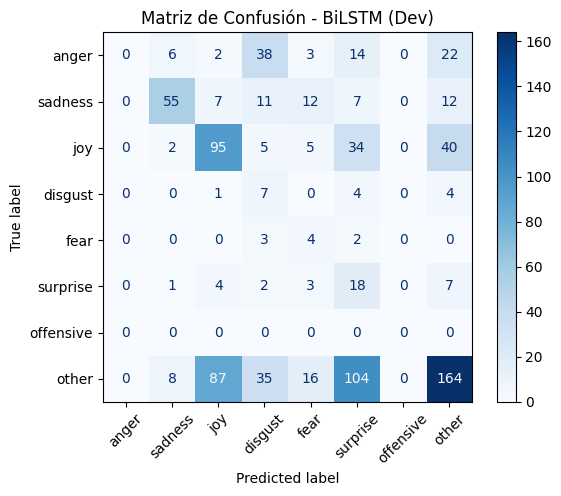


📊 Reporte (Test - BiLSTM):
              precision    recall  f1-score   support

       anger      0.000     0.000     0.000       166
     sadness      0.167     0.123     0.142       195
         joy      0.247     0.236     0.241       348
     disgust      0.011     0.061     0.018        33
        fear      0.010     0.048     0.016        21
    surprise      0.043     0.209     0.072        67
   offensive      0.000     0.000     0.000         0
       other      0.479     0.323     0.386       796

    accuracy                          0.234      1626
   macro avg      0.120     0.125     0.109      1626
weighted avg      0.310     0.234     0.261      1626



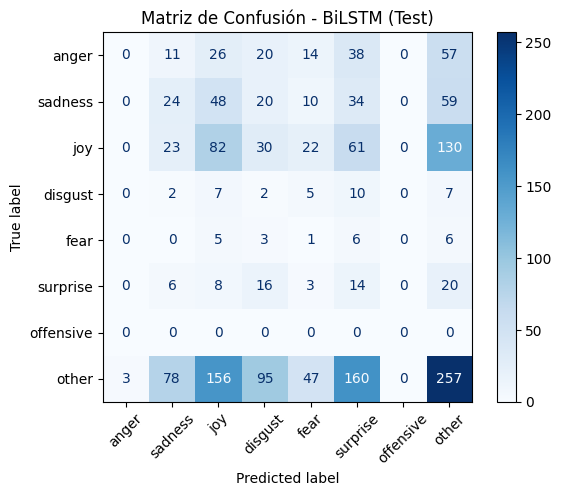

In [46]:
y_dev_pred  = eval_split(model_lstm, X_dev,  y_dev,  "Dev")
y_test_pred = eval_split(model_lstm, X_test, y_test, "Test")


Guardar resultados a CSV

In [47]:
import pandas as pd

# y_dev_pred y y_test_pred ya vienen de tu función eval_split
dev_out = dev.reset_index(drop=True).copy()
dev_out["true"] = [id2label[i] for i in y_dev]
dev_out["pred"] = [id2label[i] for i in y_dev_pred]
dev_out[["text", "event", "true", "pred"]].to_csv("bilstm_dev_results.csv", index=False)

test_out = test.reset_index(drop=True).copy()
test_out["true"] = [id2label[i] for i in y_test]
test_out["pred"] = [id2label[i] for i in y_test_pred]
test_out[["text", "event", "true", "pred"]].to_csv("bilstm_test_results.csv", index=False)

print("💾 Guardados: bilstm_dev_results.csv y bilstm_test_results.csv")


💾 Guardados: bilstm_dev_results.csv y bilstm_test_results.csv


Análisis por evento

In [48]:
def eval_por_event(df, y_pred_ids):
    tmp = df.reset_index(drop=True).copy()
    tmp["true_id"] = [label2id[e] for e in tmp["emotion"]]
    tmp["pred_id"] = y_pred_ids[:len(tmp)]
    rows = []
    for ev, g in tmp.groupby("event"):
        acc = (g["true_id"] == g["pred_id"]).mean()
        rows.append({"event": ev, "support": len(g), "accuracy": round(float(acc), 3)})
    return pd.DataFrame(rows).sort_values(["accuracy","support"], ascending=[False, False])

print("📈 DEV por evento (BiLSTM)")
display(eval_por_event(dev, y_dev_pred).head(10))

print("🧪 TEST por evento (BiLSTM)")
display(eval_por_event(test, y_test_pred).head(10))


📈 DEV por evento (BiLSTM)


,event,support,accuracy
3,LaLiga,44,0.682
2,GretaThunberg,56,0.625
7,WorldBookDay,139,0.504
4,NotreDame,123,0.480
0,ChampionsLeague,126,0.429
5,SpainElection,119,0.345
6,Venezuela,113,0.292
1,GameOfThrones,124,0.169


🧪 TEST por evento (BiLSTM)


,event,support,accuracy
2,GretaThunberg,139,0.403
3,LaLiga,119,0.387
0,ChampionsLeague,232,0.289
7,WorldBookDay,240,0.279
5,SpainElection,218,0.197
6,Venezuela,234,0.188
4,NotreDame,225,0.151
1,GameOfThrones,219,0.105


In [55]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def clasificar_emocion_bilstm(texto):
    seq = tok.texts_to_sequences([texto])
    seq_pad = pad_sequences(seq, maxlen=96, padding="post", truncating="post")
    y_prob = model_lstm.predict(seq_pad, verbose=0)
    pred_id = y_prob.argmax(axis=1)[0]
    return id2label[pred_id]


In [56]:
tweet_ejemplo = "Estoy muy feliz con los resultados del partido."

print("Predicción BiLSTM:", clasificar_emocion_bilstm(tweet_ejemplo))


Predicción BiLSTM: joy


## COMPARACION DE MODELOS

In [61]:
import pandas as pd

def comparar_modelos(df, n=10):
    # Tomamos 10 ejemplos aleatorios
    sample = df.sample(n=n, random_state=42).reset_index(drop=True)
    rows = []
    for i, row in sample.iterrows():
        texto = row["text"]
        real  = row["emotion"]

        # Predicciones
        try:
            pred_gpt   = clasificar_emocion_gpt(texto)
        except Exception as e:
            pred_gpt   = f"Error: {e}"
        pred_bert  = clasificar_emocion_bert(texto)
        pred_lstm  = clasificar_emocion_bilstm(texto)

        rows.append({
            "tweet": texto[:80] + ("..." if len(texto) > 80 else ""),
            "real": real,
            "GPT-4o": pred_gpt,
            "BERT": pred_bert,
            "BiLSTM": pred_lstm
        })

    return pd.DataFrame(rows)

# 🔍 Ejemplo con 10 tweets del test
comparaciones = comparar_modelos(test, n=10)
display(comparaciones)


,tweet,real,GPT-4o,BERT,BiLSTM
0,#GretaThunberg Nominada al premio Nobel de la ...,other,joy,other,other
1,PERO ERA MANO HIJO DE PUTA #ForçaBarça #BarçaL...,other,anger,joy,other
2,¿Alguien sabe porqué el Papa Fco. No ha dicho ...,other,surprise,surprise,disgust
3,#ChampionsLeague ¿Te perdiste los goles de Mes...,joy,other,sadness,other
4,Que mejor manera de ganar una liga que con un ...,other,joy,joy,joy
5,Ojalá el jorobado esté bien... #NotreDame,joy,sadness,sadness,sadness
6,"Pues el mejor central del mundo (sin ironía), ...",joy,other,joy,joy
7,📚💜 En la presentación de la colección “Las imp...,other,joy,joy,other
8,En poesía no acates: ataca. Aprender es acatar...,other,other,other,joy
9,Que devastador lo de #NotreDame 😢 no parece qu...,sadness,sadness,sadness,sadness


from matplotlib import pyplot as plt
import seaborn as sns
comparaciones.groupby('real').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
comparaciones.groupby('GPT-4o').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
comparaciones.groupby('BERT').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
comparaciones.groupby('BiLSTM').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['GPT-4o'].value_counts()
    for x_label, grp in comparaciones.groupby('real')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('real')
_ = plt.ylabel('GPT-4o')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['BERT'].value_counts()
    for x_label, grp in comparaciones.groupby('GPT-4o')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('GPT-4o')
_ = plt.ylabel('BERT')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['BiLSTM'].value_counts()
    for x_label, grp in comparaciones.groupby('BERT')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('BERT')
_ = plt.ylabel('BiLSTM')